In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time

from tqdm import tqdm # progress bar

import skimage
from skimage import img_as_ubyte, img_as_float32

from sklearn.model_selection import StratifiedShuffleSplit

from glob import glob

from torchsummary import summary

import math
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [2]:
#########################################
# Parameters 
#########################################

viz_image_paths = glob('/Users/racoon/Downloads/open-images-sample/*.jpg')
training_image_paths = glob('/data/open-images-dataset/train/*.jpg')
validation_image_paths = glob('/data/open-images-dataset/validation/*.jpg')

permutations = np.load("../permutations_1000.npy")

train_dataset_length = 40192 # 314 iterations
validation_dataset_length = 2048 
train_batch_size = 128
validation_batch_size = 128
num_epochs = 1500
save_after_epochs = 1 
backup_after_epochs = 10 
model_save_prefix = "nine_patch_a"
permutation_count = 1000

patch_dim = 64
jitter = 11 # gap = t* jitter
gray_portion = .30

learn_rate = 0.001
momentum = 0.974
weight_decay = 0.0005


In [3]:
#########################################
# Utilities 
#########################################

def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()
    
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for i, t in enumerate(tensor):
            t.mul_(self.std[i%3]).add_(self.mean[i%3])
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))



In [4]:


#########################################
# This class generates patches for training
#########################################

class ShufflePatchDataset(Dataset):

  def __init__(self, image_paths, patch_dim, length, jitter, transform=None):
    self.image_paths = image_paths
    self.patch_dim = patch_dim
    self.length = length
    self.gap = 2*jitter
    self.jitter = jitter
    self.color_shift = 2
    self.transform = transform

    self.sub_window_width = self.patch_dim + 2*self.jitter + 2*self.color_shift
    self.window_width = 3*self.sub_window_width
    
    self.min_image_width = window_width + 1

  def __len__(self):
    return self.length
  
  def half_gap(self):
    return self.jitter

  def random_jitter(self):
    return int(math.floor(self.jitter * 2 * random.random()))

  def random_shift(self):
    return random.randrange(self.color_shift * 2 + 1)

  # crops the patch by self.color_shift on each side
  def prep_patch(self, sub_window, gray):
 
    cropped = np.empty((self.patch_dim, self.patch_dim, 3), dtype=np.uint8)

    if(gray):

      pil_patch = Image.fromarray(sub_window)
      pil_patch = pil_patch.convert('L')
      pil_patch = pil_patch.convert('RGB')
      np.copyto(cropped, np.array(pil_patch)[self.color_shift:self.color_shift+self.patch_dim, self.color_shift:self.color_shift+self.patch_dim, :])
      
    else:

      shift = [self.random_shift() for _ in range(6)]
      cropped[:,:,0] = sub_window[shift[0]:shift[0]+self.patch_dim, shift[1]:shift[1]+self.patch_dim, 0]
      cropped[:,:,1] = sub_window[shift[2]:shift[2]+self.patch_dim, shift[3]:shift[3]+self.patch_dim, 1]
      cropped[:,:,2] = sub_window[shift[4]:shift[4]+self.patch_dim, shift[5]:shift[5]+self.patch_dim, 2]

    return cropped


  def __getitem__(self, index):
    # [y, x, chan], dtype=uint8, top_left is (0,0)
        
    image_index = int(math.floor((len(self.image_paths) * random.random())))
    pil_image = Image.open(self.image_paths[image_index]).convert('RGB')
    image = np.array(pil_image)

    # If image is too small, try another image
    if (image.shape[0] - self.min_image_width) <= 0 or (image.shape[1] - self.min_image_width) <= 0:
        return self.__getitem__(index)
    
    window_y_coord = (image.shape[0] - self.window_width) * random.random()
    window_x_coord = (image.shape[1] - self.window_width) * random.random()

    sub_window_coords = [
      (window_y_coord, window_y_coord)
      (window_y_coord, window_y_coord + self.sub_window_width)
      (window_y_coord, window_y_coord + 2 * self.sub_window_width)
      (window_y_coord + self.sub_window_width, window_y_coord)
      (window_y_coord + self.sub_window_width, window_y_coord + self.sub_window_width)
      (window_y_coord + self.sub_window_width, window_y_coord + 2 * self.sub_window_width)
      (window_y_coord + 2 * self.sub_window_width, window_y_coord)
      (window_y_coord + 2 * self.sub_window_width, window_y_coord + self.sub_window_width)
      (window_y_coord + 2 * self.sub_window_width, window_y_coord + 2 * self.sub_window_width)
    ]

    # top left corner of each patch before shifting color channels and cropping
    uncropped_patch_coords = [(y+self.random_jitter()+self.color_shift, x+self.random_jitter()+self.color_shift) for (y,x) in sub_window_coords]
    
    permutation_index = int(math.floor((permutation_count * random.random())))

    uncropped_patch_coords = [pc for _,pc in sorted(zip(permutations[permutation_index],uncropped_patch_coords))]

    uncropped_patches = [image[y:y+self.patch_dim+2*self.color_shift, x:x+self.patch_dim+2*self.color_shift] for (y,x) in uncropped_patch_coords]

    gray = random.random() < gray_portion
    patches = [self.prep_patch(patch, gray) for patch in uncropped_patches]

    if self.transform:
      patches = [self.transform(patch) for patch in patches]

    return patches, np.array(permutation_index).astype(np.int64)
    


<>:72: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:72: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?


FileNotFoundError: [Errno 2] No such file or directory: 'src/nine_patch/permutations_1000.npy'

In [128]:

##################################################
# Creating Train/Validation dataset and dataloader
##################################################

traindataset = ShufflePatchDataset(training_image_paths, patch_dim, train_dataset_length, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=train_batch_size,
                                          num_workers=4,
                                          shuffle=False)


valdataset = ShufflePatchDataset(validation_image_paths, patch_dim, validation_dataset_length, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=validation_batch_size,
                                        num_workers=4,
                                        shuffle=False)


valdataset = ShufflePatchDataset(viz_image_paths, patch_dim, 1, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=1,
                                        shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


patch_saliency 4249
patch_saliency 22
patch_saliency 1054
patch_saliency 2296


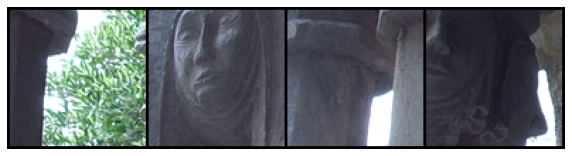

Labels: [11]


In [191]:
#############################
# Visualizing validation dataset
#############################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1]),unorm(example_batch_val[2]),unorm(example_batch_val[3])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[4].numpy()}')
